In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
def save_history(net, W_history, b_history):
    W_history.append(net[0].weight.clone().detach())
    b_history.append(net[0].bias.clone().detach())

In [3]:
def plot_hyperplanes(W, b, x=None, title='Parameters'):
    if W.shape[1] != 1:
        return

    n_neurons_output, n_neurons_input = W.shape

    for i in range(n_neurons_output):
        n = W[i]
        m = b[i]

        plt.plot(x, n*x + m)
    plt.title(title)
    plt.show()

In [4]:
domain_min, domain_max = 0, torch.pi

def init_net(layer=[1] + [10] + [1]):
    modules = []
    for i in range(len(layer)-2):
        modules.append(nn.Linear(layer[i], layer[i+1]))
        modules.append(nn.Tanh())
    
    modules.append(nn.Linear(layer[-2], layer[-1])) 
    
    net = nn.Sequential(*modules)
    
    return net

In [5]:
layer = [1] + [10] + [1]
lr = 1e-3

#  Glorot

net_glorot = init_net(layer=layer)
nn.init.xavier_uniform_(net_glorot[0].weight, gain=nn.init.calculate_gain('tanh'))
nn.init.constant_(net_glorot[0].bias, 0)
net_glorot_optim = torch.optim.Adam(net_glorot.parameters(), lr=lr)

W_glorot_history = []
b_glorot_history = []

#  He

#nn.init.kaiming_uniform_(net[0].weight, gain=nn.init.calculate_gain('tanh'))
#nn.init.constant_(net[0].bias, 0)

#  Equidistant

net_equidistant = init_net(layer=layer)

nn.init.constant_(net_equidistant[0].weight, 1)
with torch.no_grad():
    net_equidistant[0].bias = nn.Parameter(-torch.linspace(domain_min, domain_max, layer[1]))
net_equidistant_optim = torch.optim.Adam(net_equidistant.parameters(), lr=lr)

W_equidistant_history = []
b_equidistant_history = []

In [6]:
save_history(net_glorot, W_glorot_history, b_glorot_history)
save_history(net_equidistant, W_equidistant_history, b_equidistant_history)

In [7]:
def pinns_loss(n_points, f, net):
    ''' d^2/dx u = f(x) '''
    x = domain_min + torch.rand(n_points) * (domain_max - domain_min)

    xx = x.view(-1, 1)
    xx.requires_grad = True
    
    netx = net(xx)
    
    du_x = torch.autograd.grad(netx, xx, grad_outputs=torch.ones(netx.size()), retain_graph=True, create_graph=True, allow_unused=True)[0]
    ddu_x = torch.autograd.grad(du_x, xx, grad_outputs=torch.ones(du_x.size()), retain_graph=True, create_graph=True, allow_unused=True)[0]
    
    error_pde = ((ddu_x.view(x.size()) - f(x))**2).mean()
    error_bdc = (net(torch.Tensor([0]))**2)[0] + (net(torch.Tensor([torch.pi]))**2)[0]

    return error_pde + error_bdc

In [8]:
eval_points = torch.linspace(domain_min, domain_max, 100)

def train(epochs, n_points, f, u, net, optim, W_history, b_history, report_freq=1000):
    for epoch in range(epochs):
        if epoch % report_freq == 0:
            net.eval()
            with torch.no_grad():
                plt.plot(eval_points, net(eval_points.view(-1, 1)).detach().numpy())
                plt.plot(eval_points, u(eval_points), 'r--')
                plt.title(f'Epoch {epoch}')
                plt.show()

        net.train()
        loss = pinns_loss(n_points, f, net)
        loss.backward()

        optim.step()
        optim.zero_grad()
        
        print(f'epoch {epoch} -- loss {loss}', end='\n' if epoch % report_freq == 0 else '\r')
    save_history(net, W_history, b_history)

In [9]:
epochs = 5000
n_points = 500
u = lambda x: torch.sin(2*x)
f = lambda x: -4*torch.sin(2*x)

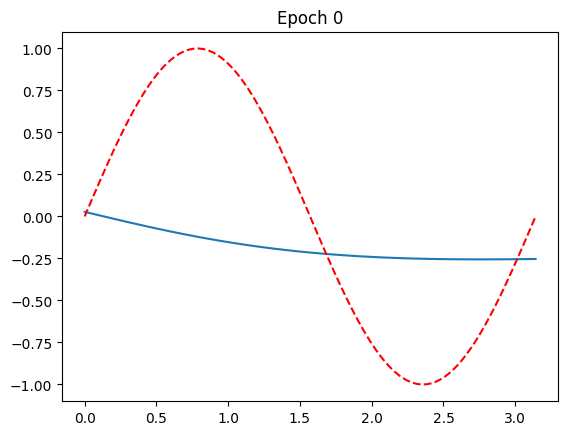

epoch 0 -- loss 8.710492134094238
epoch 999 -- loss 0.7217719554901123

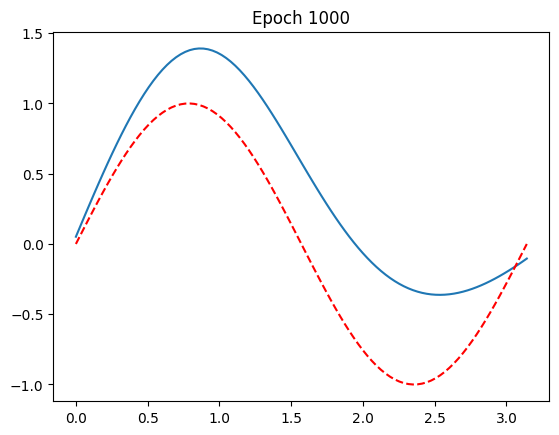

epoch 1000 -- loss 0.9206269383430481
epoch 1999 -- loss 0.021137455478310585

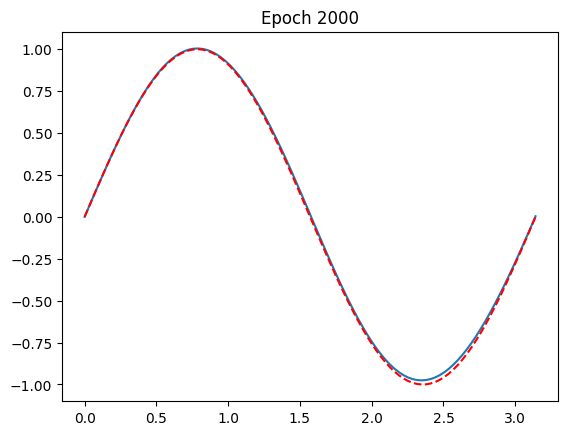

epoch 2000 -- loss 0.016775883734226227
epoch 2999 -- loss 0.0077104014344513425

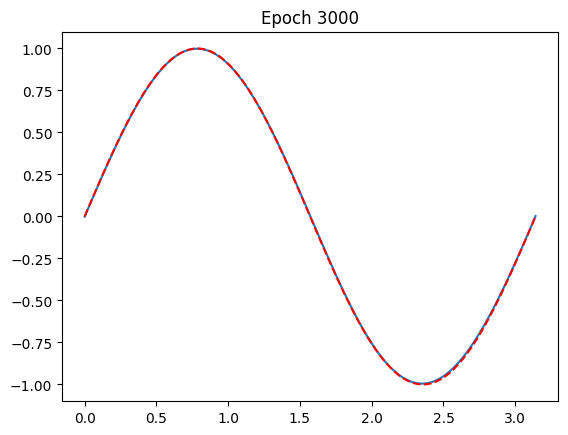

epoch 3000 -- loss 0.009963327087461948
epoch 3999 -- loss 0.0041169333271682263

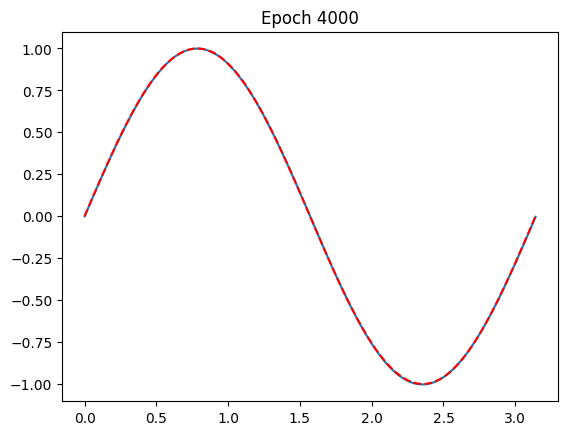

epoch 4000 -- loss 0.005035645794123411
epoch 4999 -- loss 0.0021700789220631123

In [10]:
train(epochs, n_points, f, u, net_glorot, net_glorot_optim, W_glorot_history, b_glorot_history)

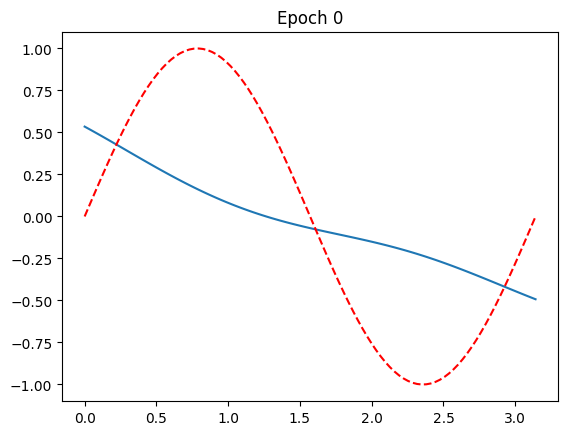

epoch 0 -- loss 9.144231796264648
epoch 999 -- loss 0.07578039169311523

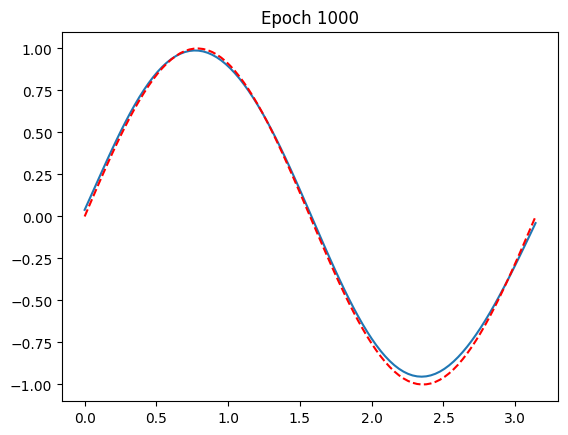

epoch 1000 -- loss 0.0762893557548523
epoch 1999 -- loss 0.0042979433201253416

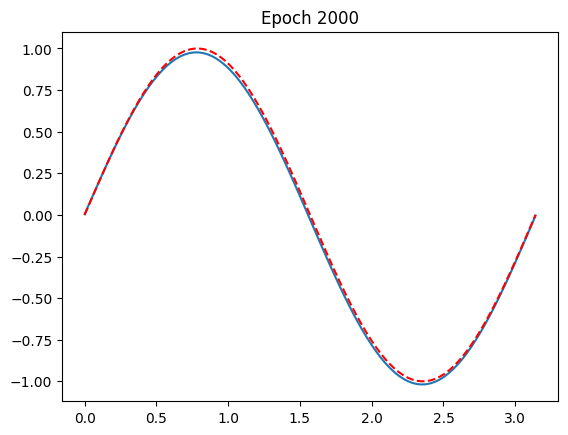

epoch 2000 -- loss 0.004080641083419323
epoch 2999 -- loss 0.0006122604245319963

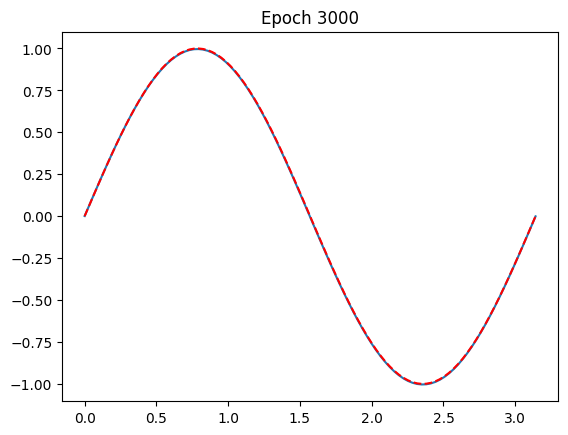

epoch 3000 -- loss 0.0005477697122842073
epoch 3999 -- loss 0.00027869018958881525

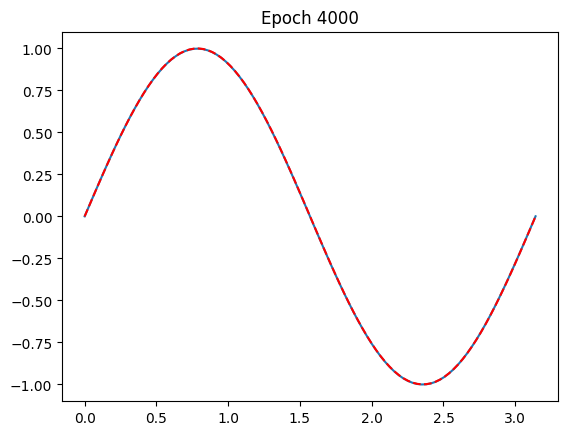

epoch 4000 -- loss 0.0002770161663647741
epoch 4999 -- loss 8.965797314886004e-056

In [11]:
train(epochs, n_points, f, u, net_equidistant, net_equidistant_optim, W_equidistant_history, b_equidistant_history)

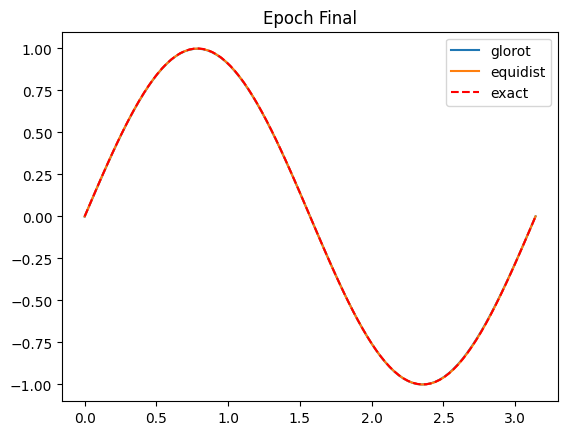

In [12]:
plt.plot(eval_points, net_glorot(eval_points.view(-1, 1)).detach().numpy(), label='glorot')
plt.plot(eval_points, net_equidistant(eval_points.view(-1, 1)).detach().numpy(), label='equidist')
plt.plot(eval_points, u(eval_points), 'r--', label='exact')
plt.title(f'Epoch Final')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

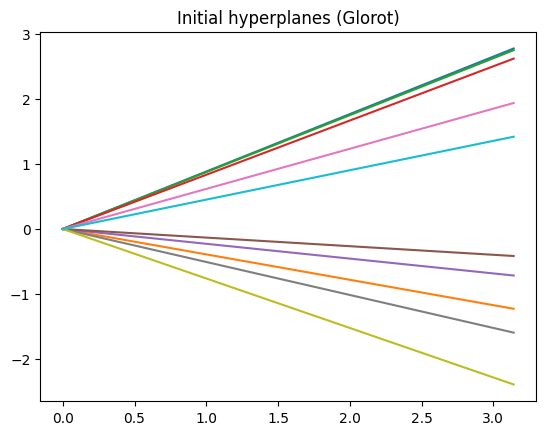

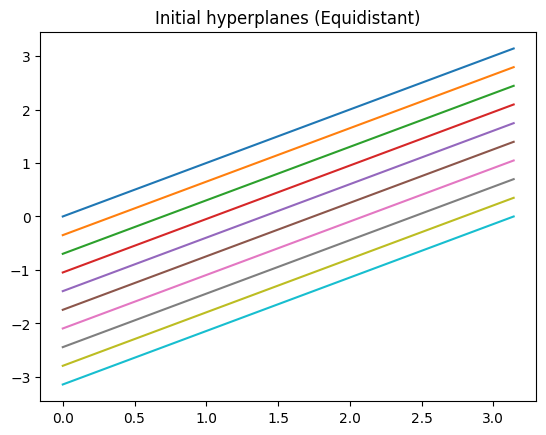

In [13]:
init_W_glorot = W_glorot_history[0]
init_b_glorot = b_glorot_history[0]

init_W_equidistant = W_equidistant_history[0]
init_b_equidistant = b_equidistant_history[0]

x = torch.linspace(domain_min, domain_max, 50)

plot_hyperplanes(init_W_glorot, init_b_glorot, x=x, title='Initial hyperplanes (Glorot)')
plot_hyperplanes(init_W_equidistant, init_b_equidistant, x=x, title='Initial hyperplanes (Equidistant)')

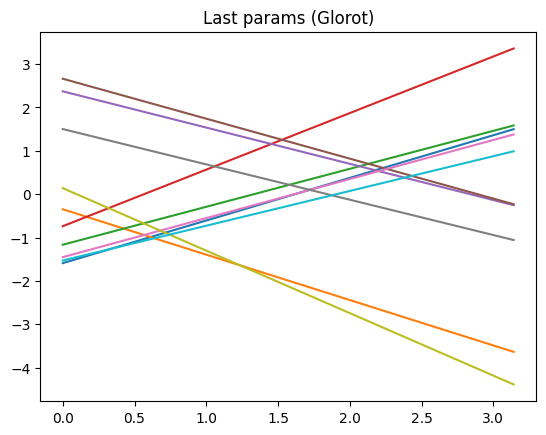

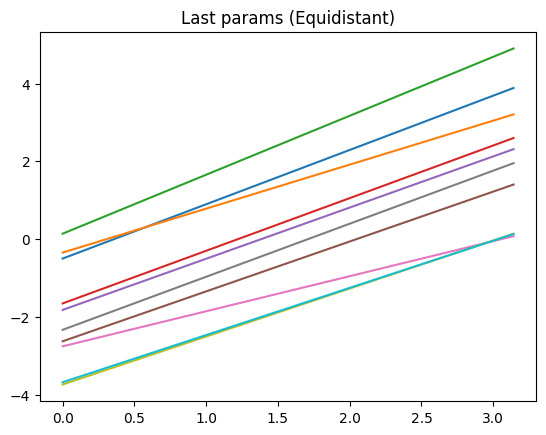

In [14]:
last_W_glorot = W_glorot_history[-1]
last_b_glorot = b_glorot_history[-1]

last_W_equidistant = W_equidistant_history[-1]
last_b_equidistant = b_equidistant_history[-1]

plot_hyperplanes(last_W_glorot, last_b_glorot, x=x, title='Last params (Glorot)')
plot_hyperplanes(last_W_equidistant, last_b_equidistant, x=x, title='Last params (Equidistant)')